In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ap_df = pd.read_csv('aapl.csv',sep=';')

In [4]:
ap_df['fecha'] = pd.to_datetime(ap_df['fecha'],format="%m/%d/%Y")

In [5]:
from datetime import timedelta

In [6]:
ap_df['fecha'] = ap_df['fecha']+timedelta(weeks=2)


In [7]:
ap_df= ap_df.set_index(ap_df['fecha'], drop=False, append=False, inplace=False, verify_integrity=False).drop('fecha', 1)

In [8]:
ap_df['Ingresos'] = [x.replace(',', '.') for x in ap_df['Ingresos']]

ap_df['Ingresos'] = ap_df['Ingresos'].astype(float)

In [9]:
ap_df.dtypes

Trimeste     object
Ingresos    float64
dtype: object

In [10]:
ap_df = ap_df[~ap_df.index.duplicated()]

In [11]:
ap_df_q=ap_df['Ingresos'].astype('float64').to_period('Q').sort_index()
ap_df_q.tail()

fecha
2020Q3     59685.0
2020Q4     64698.0
2021Q1    111439.0
2021Q2     89584.0
2021Q3     81434.0
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [12]:
ap_df=ap_df.resample("q").last()

In [13]:
ap_df.head()

,Trimeste,Ingresos
fecha,,
1990-03-31,Q1 1990,1493.4
1990-06-30,Q2 1990,1346.2
1990-09-30,Q3 1990,1364.8
1990-12-31,Q4 1990,1354.1
1991-03-31,Q1 1991,1675.5


In [14]:
medias=ap_df['Ingresos'].mean()

ap_df['Ingresos']=ap_df['Ingresos'].fillna(medias)
ap_df['Trimestre']=ap_df['Trimeste'].fillna('Q4 2005')

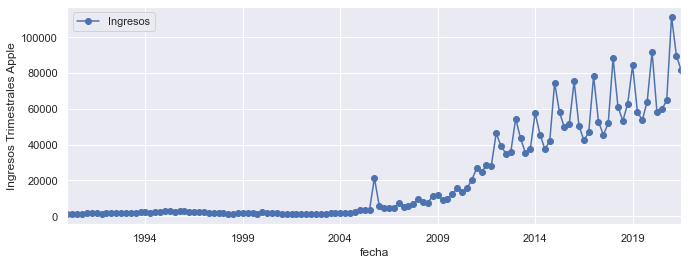

In [15]:
import seaborn as sns

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
ax = ap_df.plot(marker='o', linestyle='-')
ax.set_ylabel('Ingresos Trimestrales Apple');

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

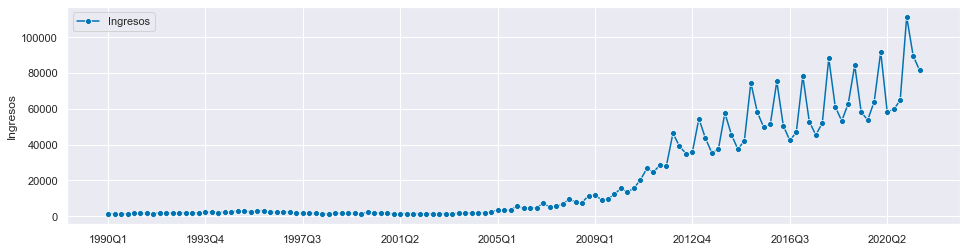

In [16]:
from sktime.utils.plotting import plot_series
plot_series(ap_df_q, labels=["Ingresos"])

In [17]:
from sktime.transformations.series.boxcox import LogTransformer

In [18]:
transformer = LogTransformer() # transfórmame la serie a trimestral
log_ap_df_q= transformer.fit_transform(ap_df_q)
log_ap_df_q.tail()

2020Q3    10.996836
2020Q4    11.077486
2021Q1    11.621233
2021Q2    11.402932
2021Q3    11.307548
Freq: Q-DEC, dtype: float64

Text(0.5, 1.0, 'Ingresos Apple: Transformación LOG')

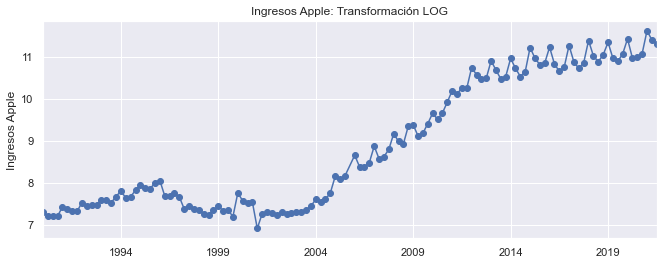

In [19]:
ax = log_ap_df_q.plot(marker='o', linestyle='-')
ax.set_ylabel('Ingresos Apple')
ax.set_title('Ingresos Apple: Transformación LOG')

Transformacion de varianza

Text(0.5, 1.0, 'Ingresos Apple: Transformación LOG')

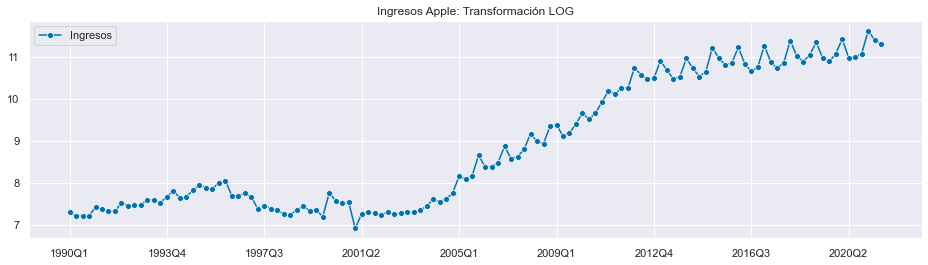

In [20]:
fig, ax =plot_series(log_ap_df_q, labels=["Ingresos"])
ax.set_title('Ingresos Apple: Transformación LOG')

Text(0.5, 1.0, 'Ingresos Apple: Transformación LOG')

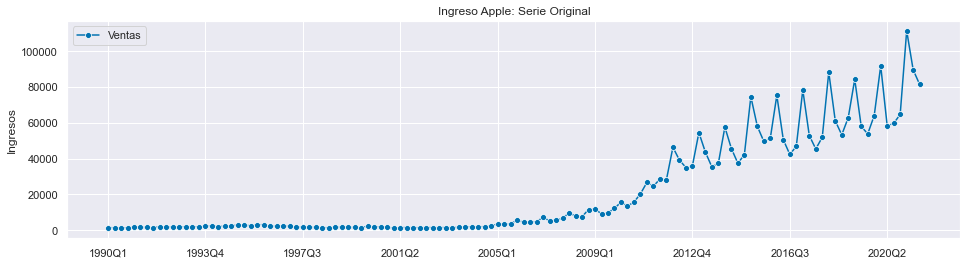

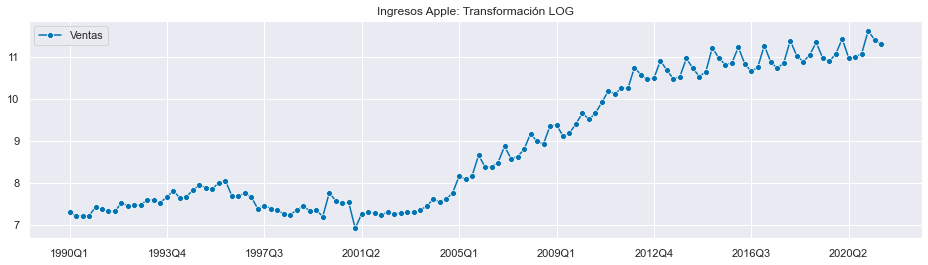

In [21]:
fig, ax =plot_series(ap_df_q, labels=["Ventas"])
ax.set_title('Ingreso Apple: Serie Original')
fig, ax =plot_series(log_ap_df_q, labels=["Ventas"])
ax.set_title('Ingresos Apple: Transformación LOG')

In [22]:
from sktime.utils.plotting import plot_correlations

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

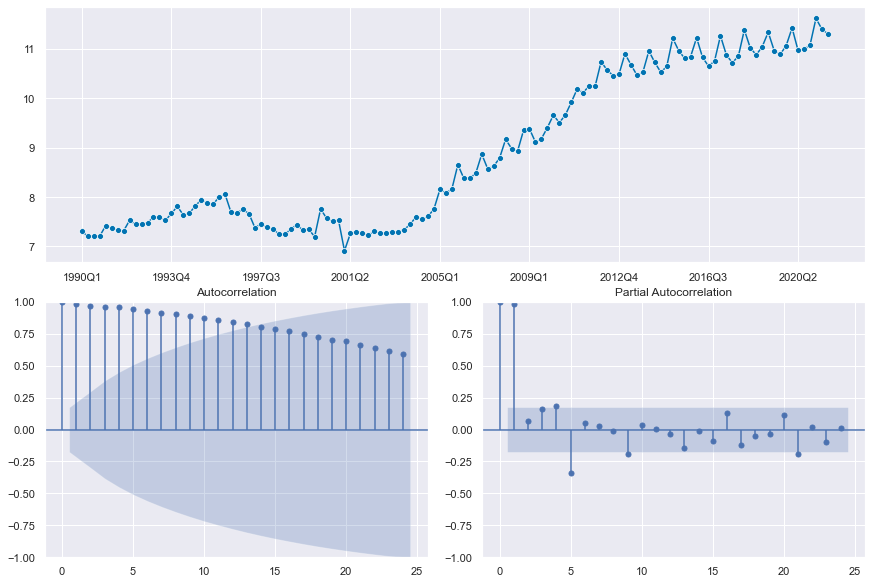

In [23]:
plot_correlations(log_ap_df_q)

In [24]:
from sktime.transformations.series.difference import Differencer

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

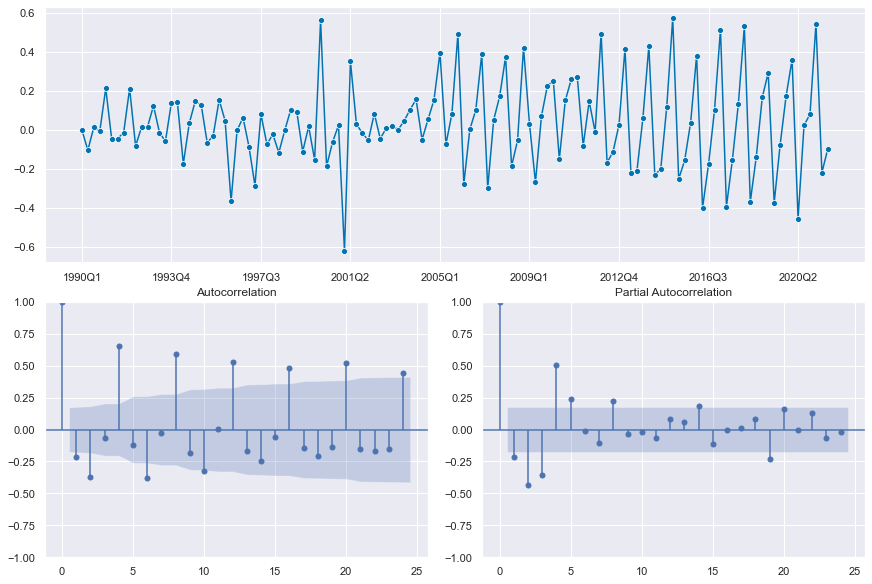

In [25]:
transf_diff=Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(log_ap_df_q))

ETS

In [26]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

119 8


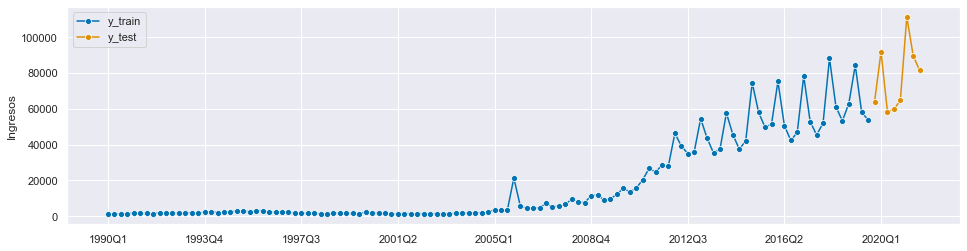

In [27]:
y_train, y_test = temporal_train_test_split(y = ap_df['Ingresos'].astype('float64').to_period('Q'), test_size=8) #test size tiene que ser 6 no?
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [28]:
from sktime.forecasting.ets import AutoETS

In [29]:
fh = np.arange(1, 13) 

In [30]:
ap_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)

In [31]:
ap_auto_model.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=4)

In [32]:
print(ap_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood               -1090.848
Date:                Sat, 08 Oct 2022   AIC                           2201.695
Time:                        16:41:43   BIC                           2229.487
Sample:                    03-31-1990   HQIC                          2212.980
                         - 09-30-2019   Scale                            0.135
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.5451      0.138      3.956      0.000       0.275       0.815
smoothing_trend        0.1853      0.050      3.680      0.000       0.087       0.284
smoothing_seasonal  

In [33]:
ap_pred = ap_auto_model.predict(fh)
print(ap_pred)

2019Q4    83508.069020
2020Q1    82222.876414
2020Q2    63460.441289
2020Q3    56537.356108
2020Q4    88621.796760
2021Q1    87181.984281
2021Q2    67231.075949
2021Q3    59847.471843
2021Q4    93735.524500
2022Q1    92141.092149
2022Q2    71001.710610
2022Q3    63157.587578
Freq: Q-DEC, dtype: float64


In [34]:
ap_pred_ints = ap_auto_model.predict_interval(fh, coverage=0.9)
ap_pred_ints

Coverage               
                 0.9               
               lower          upper
2019Q4  33938.063248  130902.933253
2020Q1  26376.470590  151536.907610
2020Q2  14716.105432  126885.415853
2020Q3   8056.875197  125405.110051
2020Q4   2557.625162  236029.649706
2021Q1  -9365.611742  249915.029297
2021Q2 -16036.522224  217380.755420
2021Q3 -23814.112042  222553.572061
2021Q4 -45246.067391  395602.324094
2022Q1 -61927.725195  462769.018719
2022Q2 -56889.478956  352482.000903
2022Q3 -64869.086531  336440.876670

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

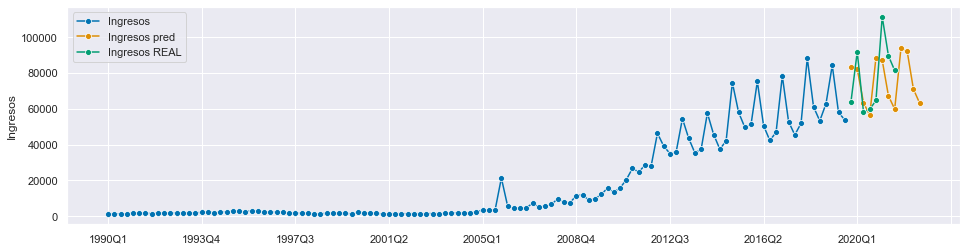

In [35]:
plot_series(y_train, ap_pred,y_test, labels=["Ingresos", "Ingresos pred", "Ingresos REAL"])

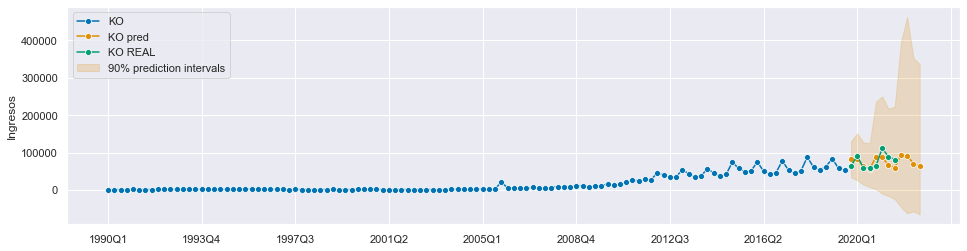

In [37]:
fig, ax = plot_series(y_train, ap_pred, y_test, labels=["KO", "KO pred", "KO REAL"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ap_pred_ints[('Coverage', 0.9, 'lower')],
    ap_pred_ints[('Coverage', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

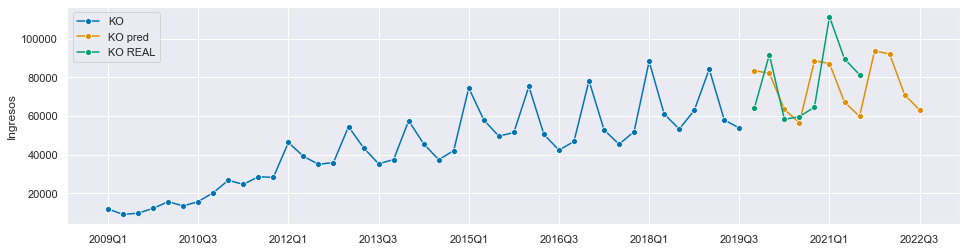

In [41]:
plot_series(y_train["2009":], ap_pred,y_test, labels=["KO", "KO pred", "KO REAL"])

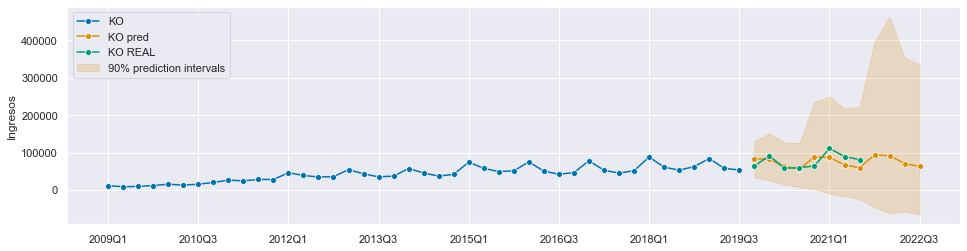

In [43]:
fig, ax = plot_series(y_train["2009":], ap_pred, y_test, labels=["KO", "KO pred", "KO REAL"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ap_pred_ints[('Coverage', 0.9, 'lower')],
    ap_pred_ints[('Coverage', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left');

In [44]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, ap_pred[0:8])

0.20644581899329498

In [45]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface
mean_absolute_percentage_error(y_test, ap_pred[0:8])

0.20644581899329498

In [46]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, ap_pred[0:8])

329234673.45243645

In [47]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, ap_pred[0:8])

18144.82497717838

arima